In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.python.ops.gen_parsing_ops import decode_raw
import numpy as np
import csv
import random
from noisegen import NoiseGen


In [2]:

#Optimization for intel CPU
TF_ENABLE_ONEDNN_OPTS=1
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0],True)

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

clipByTop = 1
clipByButtom = -1

pretrained_model = tf.keras.applications.MobileNetV3Large(include_top=True,weights='imagenet',include_preprocessing=False)
decode_predictions = tf.keras.applications.mobilenet_v3.decode_predictions

#Using preprocess_input of v2 to convert image values from [0,255] to [-1,1]. preprocess_input of v3 no longer does it.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

pretrained_model.trainable = False
input_shape = pretrained_model.input_shape[1]

# Helper function to extract labels from probability vector

loss_object = tf.keras.losses.CategoricalCrossentropy()

def display_images(image):
        probs = pretrained_model.predict(image)
        _, label, confidence = decode_predictions(probs, top=1)[0][0]
        plt.figure()
        plt.imshow(image[0]*0.5+0.5)
        plt.title('{} \n {} : {:.2f}% Confidence'.format(np.argmax(probs), label, confidence*100))
        plt.show()

def preprocess(image):
        image = tf.image.resize(image, (224, 224))
        image = preprocess_input(image)
        image = image[None, ...]
        return image

def generate_AE_demo(image,image_probs,label,d_class,confidence):
    f ,axarr = plt.subplots(2,2,figsize=(18,18))
    axarr[0][0].imshow(image[0]*0.5+0.5)
    axarr[0][0].title.set_text('Original image: {} {} : {:.2f}% Confidence'.format(np.argmax(image_probs), label, confidence*100))
    
    print('Generating adversarial example with FGSM')
    noise_obj = NoiseGen(clipByTop=1,clipByButtom=-1,pretrained_model=pretrained_model,loss_object=loss_object,
        adversarial_pattern=NoiseGen.adversarial_pattern_FGSM,eps=0.005,increment=0.005,confidence=0.7)
    delta, eps, iterCount = noise_obj.AE_generation(image,d_class)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[0][1].imshow(adv_x[0]*0.5+0.5)
    axarr[0][1].title.set_text('FGSM: {} {} : {:.2f}% Confidence\niterations: {}, noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    print('Generating adversarial example with FGNM')
    noise_obj.adversarial_pattern = NoiseGen.adversarial_pattern_FGNM
    delta, eps, iterCount = noise_obj.AE_generation(image,d_class)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[1][0].imshow(adv_x[0]*0.5+0.5)
    axarr[1][0].title.set_text('FGNM: {} {} : {:.2f}% Confidence\niterations: {} noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    print('Generating adversarial example with PGM')
    noise_obj.adversarial_pattern = NoiseGen.adversarial_pattern_PGM
    noise_obj.eps = 0.1
    noise_obj.increment = 0.01
    delta, eps, iterCount = noise_obj.AE_generation(image,d_class)
    adv_x = image - delta
    adv_x = tf.clip_by_value(adv_x, clipByButtom, clipByTop)
    adv_probs = pretrained_model.predict(adv_x)
    _, adv_label, adv_confidence = decode_predictions(adv_probs, top=1)[0][0]
    axarr[1][1].imshow(adv_x[0]*0.5+0.5)
    axarr[1][1].title.set_text('PGM: {} {} : {:.2f}% Confidence\niterations: {} noise: {}'.format(
        np.argmax(adv_probs), adv_label, adv_confidence*100,iterCount, tf.linalg.norm(image[0]-adv_x[0]).numpy()))

    plt.show()


In [3]:
image_path = tf.keras.utils.get_file('Lion_waiting_in_Namibia.jpg','https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg')

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)


In [5]:
#Random target
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
dNumber = random.randrange(0,1000)
while np.argmax(image_probs) == dNumber:
    dNumber = random.randrange(0,1000)
d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Random class target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,d_class,confidence)


1/1 [==============================] - 0s 30ms/step
Image: 291 lion, confidence: 0.9915913343429565
Random class target: 722 ping-pong_ball
Generating adversarial example with FGSM
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 4s 4s/step
Image: 291 lion, confidence: 0.9915913343429565
Class based target: 276 hyena
Generating adversarial example with FGSM
1/1 [==============================] - 0s 26ms/step
Generating adversarial example with FGNM
1/1 [==============================] - 0s 26ms/step
Generating adversarial example with PGM
1/1 [==============================] - 0s 26ms/step


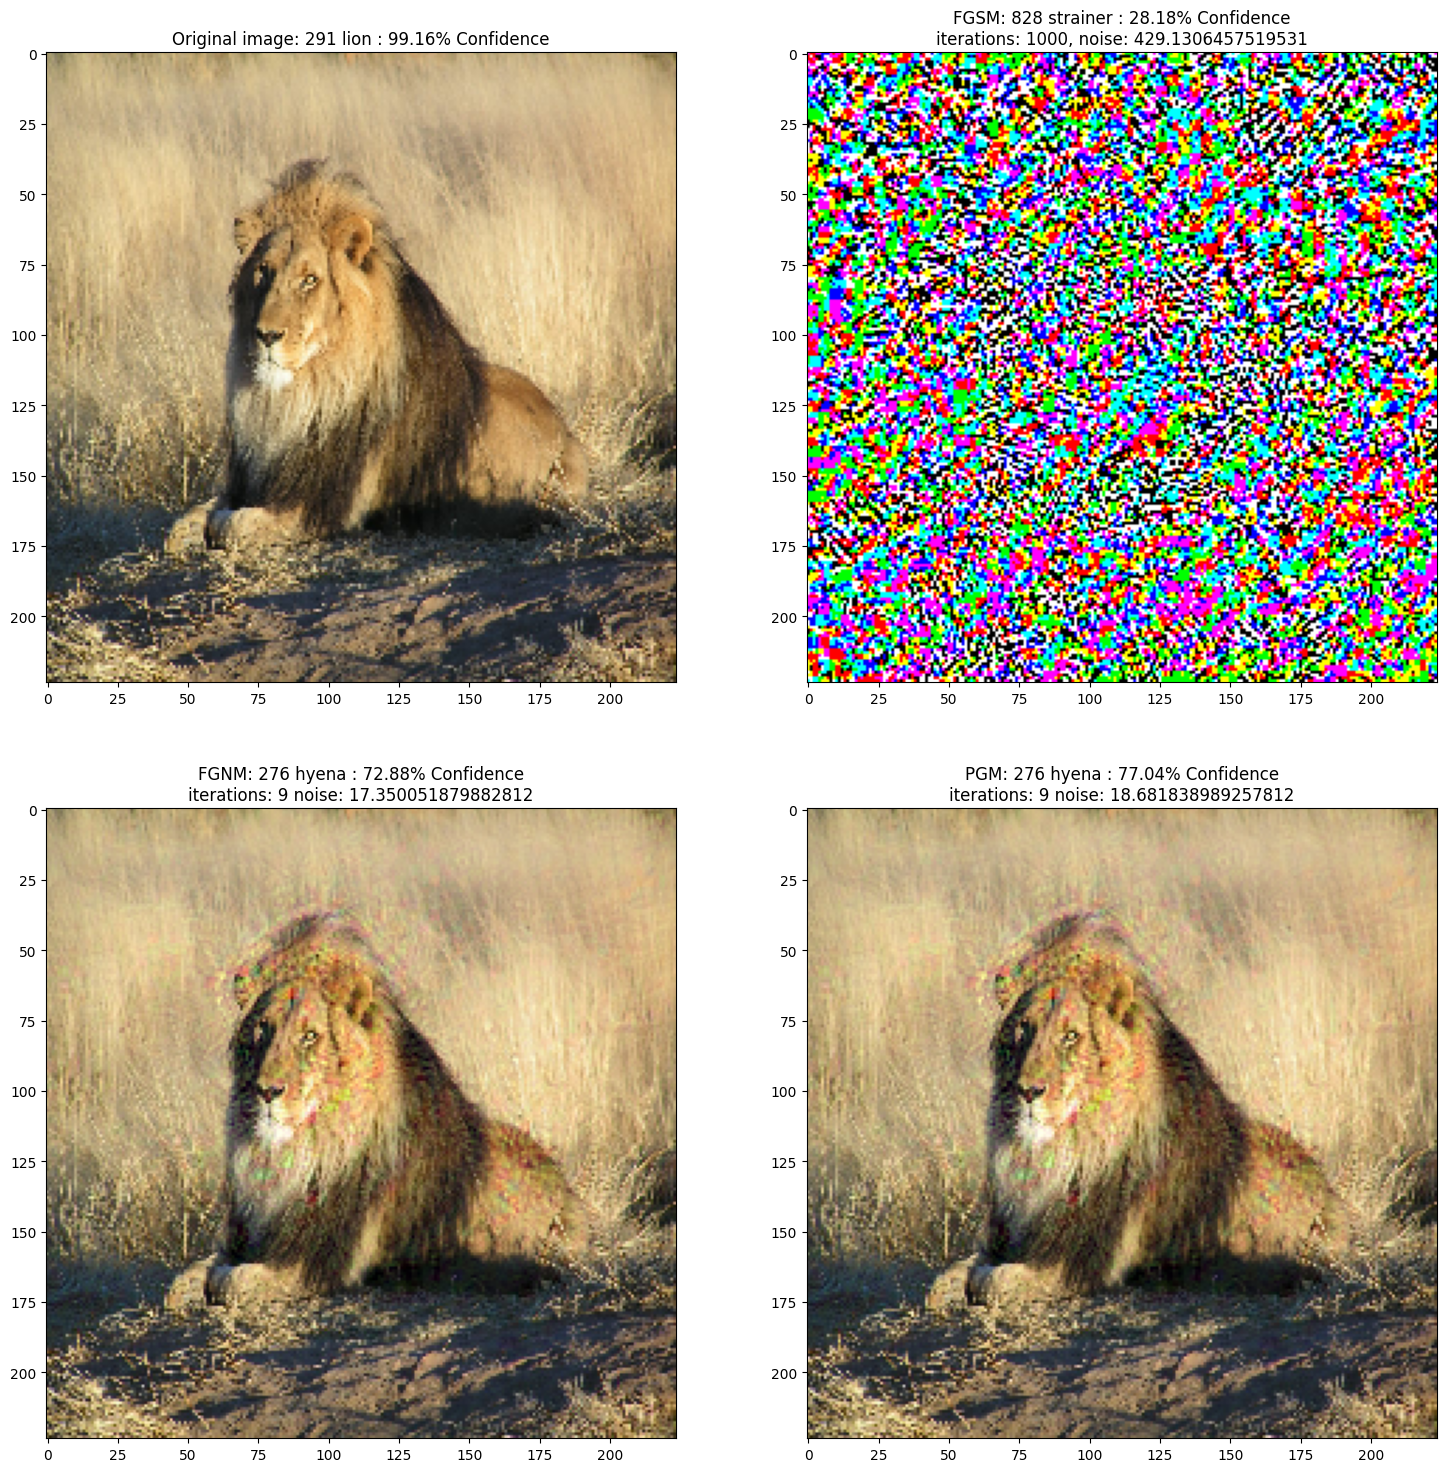

In [4]:
#Distance-based target
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
dNumber = np.argsort(image_probs[0])[-10]
d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Class based target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,d_class,confidence)

1/1 [==============================] - 0s 47ms/step
Image: 291 lion, confidence: 0.9915913343429565
Relation network target: 348 ram
Generating adversarial example with FGSM
1/1 [==============================] - 0s 29ms/step
Generating adversarial example with FGNM
1/1 [==============================] - 0s 27ms/step
Generating adversarial example with PGM
1/1 [==============================] - 0s 27ms/step


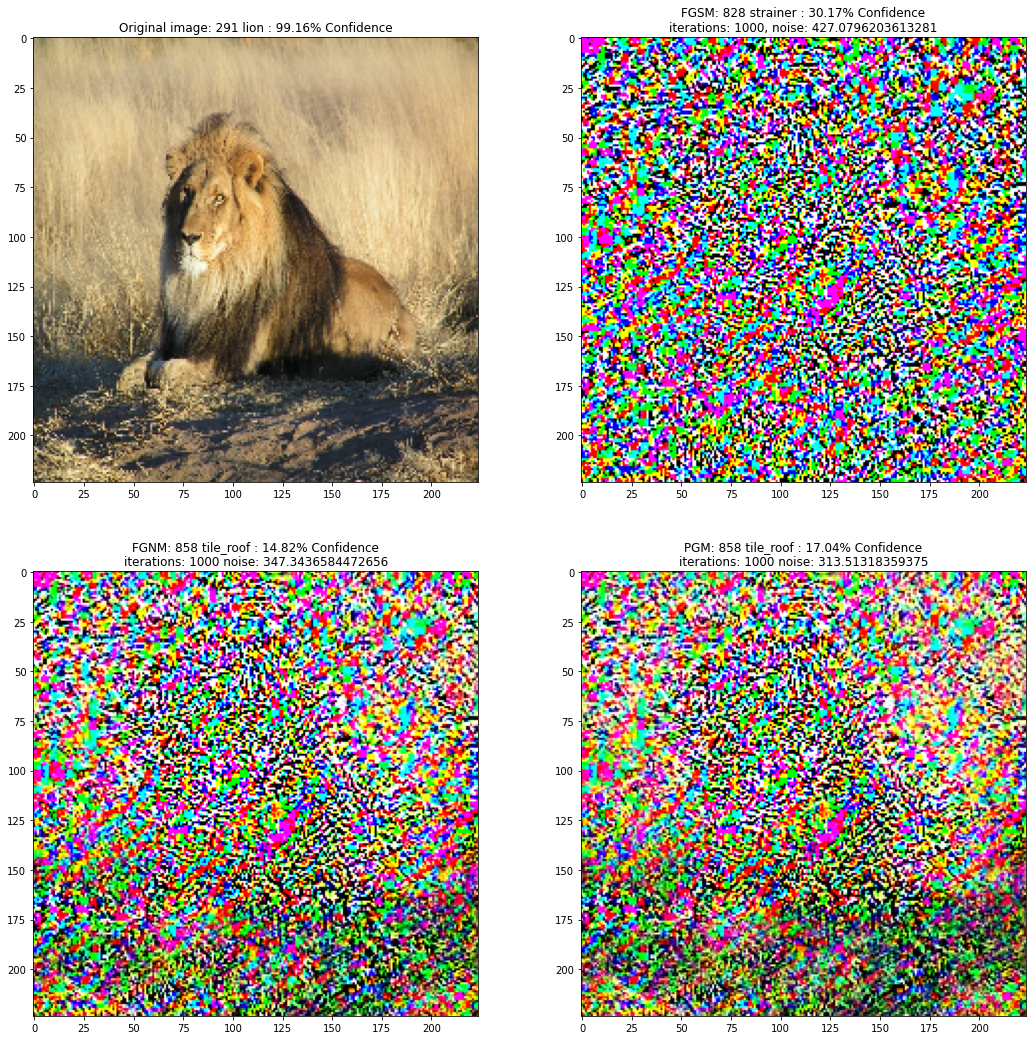

In [5]:
#Class relation network
image_probs = pretrained_model.predict(image)
_, label, confidence = decode_predictions(image_probs, top=1)[0][0]
with open('RelNet.csv',mode='r') as resf:
    reader = csv.DictReader(resf)
    dslist = list(reader)
dNumber = int(dslist[np.argmax(image_probs)]['20'])

d_class = tf.one_hot(dNumber, 1000)
d_class = tf.reshape(d_class, (1, 1000))
print('Image: {} {}, confidence: {}'.format(np.argmax(image_probs),label,confidence))
print('Relation network target: {} {}'.format(dNumber,decode_predictions(d_class.numpy(), top=1)[0][0][1]))

generate_AE_demo(image,image_probs,label,d_class,confidence)
